## Гипотезы

1. У Игоря есть гипотеза, что одно из двух дополнительных действий
может вызывать целевое действие: то есть пользователи,
совершившие event_1 или event_2, с большей вероятностью совершат
и целевое действие. Нужно проверить, так ли это.

2. Другая задача — понять, какие именно пользователи
совершают целевые действия. Менеджер продукта выдвигает
гипотезу, что чаще всего по несколько раз фильмы/сериалы
покупают одни и те же пользователи, то есть небольшой
процент пользователей обеспечивает почти все действия,
приносящие нам прибыль.

In [0]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as mpl

Загрузка данных. В этом варианте данные загружаются из облака Amazon, что обеспечивает единство результатов, но нужно подключение к Интернет.  Если подключения нет, то ниже показана загрузка из локального файла (нужно раскомментировать)

In [0]:
# Загрузка исходных данных из сжатого JSON файла в облаке
df = pd.read_json("https://miscelanneous.s3-eu-west-1.amazonaws.com/SkillFactory/SDA5_CaseA6/case6.json.gz", 
                  orient='records', convert_dates='created_at',
                  date_unit='ns', compression='gzip')

In [0]:
# Загрузка исходных данных из локального JSON файла
# df = pd.read_json("case6.json", orient='records', convert_dates='created_at',
#                  date_unit='ns')

In [4]:
# Кол-во уникальных пользователей всего и тех из них, которые совершили целевое действие,
# плюс считаем конверсию.
users_count        = df.user_id.nunique()
users_target_count = df[df.event_type=='target_event'].user_id.nunique()
conversion         = users_target_count / users_count
print("Всего пользователей: {0}, из них покупателей: {1}, конверсия: {2:.2%}".format(users_count, users_target_count, conversion))

Всего пользователей: 7351, из них покупателей: 980, конверсия: 13.33%


# Собирание сводной статистики
Решил собирать статистику в виде таблицы, где строки соответствуют идентификаторам пользователей, а колонки событиям, таким как регистрация, установка тарифа, просмотр трейлера, рекомендаций, покупка.  В этом случае будет проще искать связи между колонками.

In [0]:
pt = df.pivot_table(values='created_at', index='user_id', columns='event_type', aggfunc='count')

# Получившуюся сводную таблицу можно проверить, расчитав, к примеру, конверсию:
assert(conversion == pt.target_event.count()/len(pt))

Надо иметь в виду, что здесь не нужно суммировать, так как примерно 170 пользователей делали больше
одной покупки (pt.target_event.value_counts())

В таблице user_events2 колонки `registration` и `tarif_set` неинформативны, они содержат
единицу для каждого пользователя (легко проверить `value_counts()`), избавляюсь от них.

In [0]:
pt.drop(labels=['registration', 'tarif_set'], axis=1, inplace=True)

Теперь смотрим, какие действия пользователя приводят к целевому действию.
Например, активация совершенно необходима для всего остального — если активации не произошло, не произойдёт и никаких других событий:

In [7]:
pt[pt.activation.isnull()].count(axis=0)

event_type
activation      0
event_1         0
event_2         0
target_event    0
dtype: int64

  Так что можно расчитать конверсию из посетителей в активированных пользователей, а дальше делать расчёты после исключения неактивированных UID.

Посчитаю конверсию из посетителей в пользователей, а потом из пользователей в покупателей. Для второй части вопроса создам новый датафрейм (объём данных невелик, можно не экономить память), в котором не будет неактивированных пользователей, и выброшу колонку `activation`.
Произведение этих двух конверсий, даст общую конверсию — можно проверить себя `assert`-ом.

In [8]:
print("Conversion from visitors to activated users: {:0.2%}".format(pt.activation.count()/len(pt)))
# drop unregistered users
pt1 = pt[pt.activation.notnull()].drop(labels=['activation'], axis=1)
print("Conversion from activated users to buyers: {:0.2%}".format( pt1.target_event.count()/len(pt1) ))
assert(conversion == (pt.activation.count()/len(pt)) * (pt1.target_event.count()/len(pt1)))

Conversion from visitors to activated users: 83.06%
Conversion from activated users to buyers: 16.05%


## Проверяем гипотезу о связи целевого действия с просмотром трейлера и с получением персональных рекомендаций

### Рекомендации

Теперь мы знаем, от какой конверсии нужно отталкиваться, и можем попробовать понять, влияют ли события `event_1`, `event_2` или их комбинация на вероятность покупки.

In [10]:
print("Всего активированных пользователей: {0}, целевых событий с рекомендациями: {1}, без рекомендаций: {2}".format(len(pt1), pt1.event_1.count(), len(pt1) - pt1.event_1.count()))

Всего активированных пользователей: 6106, целевых событий с рекомендациями: 2844, без рекомендаций: 3262


Условная вероятность целевого события при разных значениях в колонке `event_1`:

In [9]:
P_trg_evt1   = pt1[pt1.event_1.notnull()].target_event.count()/(pt1.event_1.count())
P_trg_n_evt1 = pt1[pt1.event_1.isnull()].target_event.count()/(len(pt1) - pt1.event_1.count())
print("Конверсия для пользователей, запрашивавших рекомендации: {:.2%}, а не запрашивавших: {:.2%}".format(P_trg_evt1, P_trg_n_evt1))

Конверсия для пользователей, запрашивавших рекомендации: 24.40%, а не запрашивавших: 8.77%


Можно сказать, что среди пользователей, просматривавших персональные рекомендации, вероятность совершения покупки втрое выше, чем среди не запрашивавших таких рекомендаций.  Это равносильно высказыванию, что персональные рекомендации заметно повышают конверсию.

### Трейлер

Аналогично расчитаем для события `event_2`: просмотр трейлера.

In [100]:
print("Всего пользователей: {0}, смотрели трейлеры: {1}, не смотрели: {2}".format(
    len(pt1), pt1.event_2.count(), len(pt1) - pt1.event_2.count())
)

Всего пользователей: 6106, смотрели трейлеры: 5332, не смотрели: 774


In [11]:
P_trg_evt2   = pt1[pt1.event_2.notnull()].target_event.count()/(pt1.event_2.count())
P_trg_n_evt2 = pt1[pt1.event_2.isnull()].target_event.count()/(len(pt1) - pt1.event_2.count())
print("Конверсия для пользователей, смотревших трейлеры: {:.2%}, не смотревших: {:.2%}".format(P_trg_evt2, P_trg_n_evt2))

Конверсия для пользователей, смотревших трейлеры: 16.15%, не смотревших: 15.37%


Непохоже, чтобы факт просмотра трейлера влиял на решение о покупке фильма.  Вероятности отличаются, но не кардинально.

### Комбинация событий

Попробуем ещё скомбинировать события `event_1` и `event_2` (то есть рассмотрим случаи, когда происходят оба этих события).  Посмотрим количество таких комбинаций в выборке (создам дополнительный список из булевых значений):

In [13]:
events_vec = pt1['event_2'].notnull() & pt1['event_1'].notnull()
events_vec.value_counts()
print("Количество комбинаций event_1 + event_2: {:d}".format(len(pt1[events_vec])))

Количество комбинаций event_1 + event_2: 2481


И коэффициент конверсии среди этих пользователей:

In [20]:
print("Конверсия при комбинации event_1 + event_2: {:.2%}".format(
    (pt1[events_vec].target_event.count()) / ( len(pt1[events_vec]) ))
)

Конверсия при комбинации event_1 + event_2: 24.67%


Вероятность покупки в случае, когда пользователь получил персональные рекомендации *и* просмотрел трейлер, не сильно отличается от случая, когда он только просмотрел рекомендации.  То есть и здесь можно сказать, что просмотр трейлера не влияет на решение о покупке медиа.

### Проверяем другим способом

Заход с другой стороны: выбираю только тех пользователей, которые совершили покупки,
и среди них буду искать разницу частот событий `event_1` и `event_2`:

In [102]:
pt2 = pt1[pt1.target_event.notnull()]
users = len(pt1)
buyers = len(pt2)
print("""% получивших рекомендации среди покупателей: {0:.2%}
% просмотревших трейлеры среди покупателей: {1:.2%}
При этом проценты среди всех пользователей: 
  получали рекомендации: {2:.2%}
  смотрели трейлеры: {3:.2%}
""".format(
    pt2.event_1.count() / buyers,
    pt2.event_2.count() / buyers,
    pt1.event_1.count() / users,
    pt1.event_2.count() / users
))


% получивших рекомендации среди покупателей: 70.82%
% просмотревших трейлеры среди покупателей: 87.86%
При этом проценты среди всех пользователей: 
  получали рекомендации: 46.58%
  смотрели трейлеры: 87.32%



Мы подошли к тому же выводу с другой стороны: для пользователя, который получал рекомендации, вероятность покупки значительно выше, то есть получение рекомендаций коррелировано с покупкой.

Выведем дополнительно проценты получивших рекомендации и просмотревших трейлеры среди пользователей, которые (пока?) не стали покупателями.

In [16]:
pt3 = pt1[pt1.target_event.isnull()]
print("% получивших рекомендации среди НЕпокупателей: {:.2%}".format(pt3.event_1.count() / len(pt3)))
print("% просмотревших трейлеры среди НЕпокупателей : {:.2%}".format(pt3.event_2.count() / len(pt3)))

% получивших рекомендации среди НЕпокупателей: 41.94%
% просмотревших трейлеры среди НЕпокупателей : 87.22%


Снова приходим к тому, что предсказательную ценность имеет параметр `event_1` (рекомендации), а `event2` (трейлеры) слабо коррелирован с покупкой.

## Гипотеза 2: основные покупки совершает только часть пользователей, то есть существуют пользователи, совершившие много целевых действий, и они приносят основные продажи

Максимум покупок на пользователя: 9.0


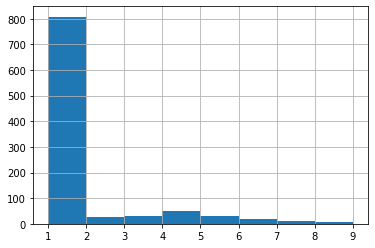

In [17]:
# На всякий случай пересоздаём таблицу, в которой только покупатели
pt2 = pt[pt.target_event.notnull()]
print("Максимум покупок на пользователя: {0}".format(pt2.target_event.max()))
__ = pt2.target_event.hist(bins=8)

Из гистограммы видно, что существует много пользователей, купивших доступ один раз, и группа пользователей, которые покупали медиа многократно (то есть более одного раза).  Но не очень понятно распределение покупок: у каких клиентов их больше, у одноразовых или повторных? Просуммируем покупки по этим категориям:

In [94]:
print("""Целевые действия (покупки): 
Всего: {0:0g} повторные покупатели: {1:0g} ({6:.2%}), новые покупатели: {2:0g} ({7:.2%}),
Покупатели: 
Всего {3:0g}, повторных {4:0g} ({8:.2%}), однократных: {5:0g} ({9:.2%})""".format(
    pt2.target_event.sum(),  #0
    pt2[pt2.target_event > 1].target_event.sum(), #1
    pt2[pt2.target_event == 1].target_event.sum(), #2
    len(pt2), #3
    len(pt2[pt2.target_event > 1]), #4
    len(pt2[pt2.target_event == 1]), #5
    pt2[pt2.target_event > 1].target_event.sum() / pt2.target_event.sum(), #6
    pt2[pt2.target_event == 1].target_event.sum() / pt2.target_event.sum(), #7
    len(pt2[pt2.target_event > 1]) / len(pt2), #8
    len(pt2[pt2.target_event == 1]) / len(pt2), #9
))
# Проверяем, что в цифрах не запутались.
assert(len(pt2) == len(pt2[pt2.target_event > 1]) + len(pt2[pt2.target_event == 1]))
assert(pt2.target_event.sum() == (pt2[pt2.target_event > 1].target_event.sum() + 
                                  pt2[pt2.target_event == 1].target_event.sum())
)

Целевые действия (покупки): 
Всего: 1543 повторные покупатели: 735 (47.63%), новые покупатели: 808 (52.37%),
Покупатели: 
Всего 980, повторных 172 (17.55%), однократных: 808 (82.45%)


Получается, что 172 повторных клиента совершили почти столько же покупок, сколько 808 однократных покупателей. 

Если группировать клиентов по количеству покупок (например, "по 4 покупки совершили 10 покупателей"), то получается такой датафрейм (учитываются только клиенты):

In [99]:
trg_evt_count_by_uid = pt2.drop(['event_1', 'event_2'], axis=1).reset_index()
trg_evt_count_by_uid.columns = ("UID", "transactions")
total_buyers = trg_evt_count_by_uid.transactions.count()
total_transactions = trg_evt_count_by_uid.transactions.sum()
uids_by_transactions_count = trg_evt_count_by_uid.groupby('transactions', as_index=True, axis=0).count()
uids_by_transactions_count.columns=['users']
uids_by_transactions_count['part_of_buyers'] = uids_by_transactions_count.users / total_buyers
uids_by_transactions_count['part_of_transactions'] = (
    uids_by_transactions_count['users'] * uids_by_transactions_count.index /
    total_transactions )
# Проверяю, что наши проценты в сумме = 100 и прочие показатели суммируются, как надо (логический контроль)
assert(uids_by_transactions_count.users.sum() == total_buyers)
assert((uids_by_transactions_count.index * uids_by_transactions_count.users).sum() == total_transactions)
assert(uids_by_transactions_count.part_of_buyers.sum() == 1)
assert(uids_by_transactions_count.part_of_transactions.sum() == 1)
print(uids_by_transactions_count)
print("\nTotal buyers: {0}, total transactions: {1}".format(total_buyers, total_transactions))


              users  part_of_buyers  part_of_transactions
transactions                                             
1.0             808        0.824490              0.523655
2.0              26        0.026531              0.033701
3.0              31        0.031633              0.060272
4.0              49        0.050000              0.127025
5.0              29        0.029592              0.093973
6.0              20        0.020408              0.077771
7.0               9        0.009184              0.040830
8.0               6        0.006122              0.031108
9.0               2        0.002041              0.011666

Total buyers: 980, total transactions: 1543.0


В цифрах не очень наглядно, покажу на картинке:

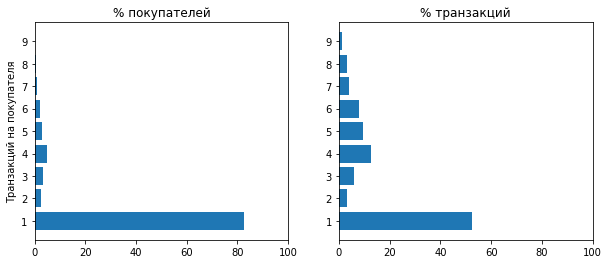

In [90]:
# Вывожу картинку
fig, ax = mpl.subplots(1,2)
fig.set_size_inches(10,4)
ax[0].set_xlim(0,100)
ax[0].set_title('% покупателей')
ax[0].set_ylabel('Транзакций на покупателя')
ax[0].set_yticks(range(1,10))
ax[1].set_xlim(0,100)
ax[1].set_title('% транзакций')
ax[1].set_yticks(range(1,10))
ax[0].barh(uids_by_transactions_count.index, uids_by_transactions_count.part_of_buyers * 100)
ax[1].barh(uids_by_transactions_count.index, uids_by_transactions_count.part_of_transactions * 100)
mpl.show()

Итак, чуть меньше 1/5 покупателей, которые оплачивали доступ к медиа несколько раз, принесли нам почти половину прибыли.  Это не «большая часть», но заметная: есть смысл задуматься об удержании покупателей.  

Сколько средств есть смысл вкладывать в удержание клиентов, в этом анализе не рассматривается, это предмет отдельного исследования.

## Выводы

По результатам рассмотрения трёх гипотез можно сказать, что:

### Гипотеза 1А: пользователи, которые просматривали рекомендации, совершают больше покупок.

Эта гипотеза *подтверждается* данными.

### Гипотеза 1Б: пользователи, которые смотрели трейлеры, совершают больше покупок

Эта гипотеза *не подтверждается*, влияния просмотра трейлеров на готовность покупать не обнаружено.

### Гипотеза 2: Б*о*льшую часть прибыли приносят постоянные клиенты

Гипотеза не подтверждается: повторные покупки составляют значительную часть, но не большинство транзакций.

Возможно, при повышении внимания к удержанию пользователей, будет больше повторных покупок, и это соотношение изменится.